### Motor Flow

a reformating action generation as sampling from a conditional distribution. first sample from a simplier dist and we simulate learned ODE to achieve our goal dist

In [55]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import random
import os, glob, math
import numpy as np
import matplotlib.pyplot as plt

### Data Preprocessing and Batch

In [56]:
DATA_PATH = "/home/santari/Projects/motor_gpt/data/processed/svla_so101_actions.pt"
payload = torch.load(DATA_PATH, map_location='cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [57]:
if isinstance(payload, dict):
    episodes = payload['episodes']
else:
    episodes = payload


print(f"Loaded {len(episodes)} episodes")
print("Example episode tensor shape:", episodes[0].shape)  # (T_ep, 6)
lengths = [ep.shape[0] for ep in episodes]
print("Episode lengths: min/max/mean =", min(lengths), max(lengths), sum(lengths)/len(lengths))

Loaded 50 episodes
Example episode tensor shape: torch.Size([303, 6])
Episode lengths: min/max/mean = 183 306 238.78


In [58]:
SEED = 42
TRAJ_SIZE = 30

N_TEST = 5
N_VAL = 5

# sanity: ensure block_size fits in shortest episode for next-step targets
assert min(lengths) > TRAJ_SIZE, "TRAJ_SIZE too big for at least one episode."

indices = list(range(len(episodes)))
random.seed(SEED)
random.shuffle(indices)

test_ids = indices[:N_TEST]
val_ids  = indices[N_TEST:N_TEST+N_VAL]
train_ids = indices[N_TEST+N_VAL:]

train_eps = [episodes[i] for i in train_ids]
val_eps   = [episodes[i] for i in val_ids]
test_eps  = [episodes[i] for i in test_ids]

print("Split counts (train/val/test):", len(train_eps), len(val_eps), len(test_eps))
print("Train min/max length:", min(ep.shape[0] for ep in train_eps), max(ep.shape[0] for ep in train_eps))
print("Test indices:", test_ids)
print("Val indices:", val_ids)
print("Train indices:", train_ids)

Split counts (train/val/test): 40 5 5
Train min/max length: 183 306
Test indices: [25, 23, 19, 11, 4]
Val indices: [45, 26, 9, 29, 16]
Train indices: [31, 21, 12, 3, 39, 38, 10, 24, 35, 0, 43, 18, 33, 48, 41, 30, 28, 20, 22, 42, 46, 36, 32, 44, 13, 49, 47, 2, 27, 37, 5, 34, 6, 8, 14, 15, 17, 1, 7, 40]


In [59]:
def prep_episode_metadata(episodes, trajectory_len):
    max_starts = []
    for ep in episodes:
        T = ep.shape[0]
        max_start = T - trajectory_len 
        max_starts.append(max_start)
    return max_starts


In [60]:
def get_batch_train(episodes, window_lens, trajectory_len, batch_size, device):
    # generate which episodes to draw from for this batch
    idx_samples = torch.randint(0,len(episodes), (batch_size,))
    x_list , context_list = [], []
 
    for sample in range(batch_size):
  
        eps_idx = idx_samples[sample].item()
        eps = episodes[eps_idx]

        # generate a randon starting_idx within our valid range
        max_start = window_lens[eps_idx]
        start = torch.randint(0, max_start+1, (1,)).item()
       
        # context length = trajectory_len - 1
        context = eps[start : start + trajectory_len - 1]
        x = eps[start + trajectory_len - 1]

        x_list.append(x)
        context_list.append(context)

    X = torch.stack(x_list, dim=0).to(device)
    context = torch.stack(context_list, dim=0).to(device)

    return X, context

In [61]:
window_lens = prep_episode_metadata(train_eps, trajectory_len=30)

print(window_lens)
print(len(window_lens))
print(type(window_lens))

[242, 194, 180, 153, 208, 226, 186, 193, 232, 273, 251, 184, 209, 242, 276, 258, 194, 213, 207, 233, 273, 224, 240, 231, 201, 241, 229, 200, 173, 197, 201, 177, 194, 196, 193, 196, 213, 236, 173, 263]
40
<class 'list'>


In [62]:
X, context = get_batch_train( train_eps, window_lens, batch_size=4, trajectory_len=30, device="cpu")

print(X.shape)
print(context.shape)
print(X)
print(context)

torch.Size([4, 6])
torch.Size([4, 29, 6])
tensor([[  5.0000, -99.1579,  99.5448,  74.0756, -54.8230,   1.7774],
        [-83.3088, -11.8316,  46.4725,  64.3009, -92.4298,  20.4019],
        [ 11.9853, -87.1158,  88.5298,  52.7412, -58.8767,  24.5750],
        [  5.5882, -99.1579,  99.5448,  73.8207, -54.8230,   1.7002]])
tensor([[[ 2.0588e+01, -4.0884e+01,  4.4288e+01,  7.1356e+01, -4.1245e+01,
           1.1592e+00],
         [ 1.6838e+01, -4.1474e+01,  4.6472e+01,  6.9146e+01, -4.3199e+01,
           1.1592e+00],
         [ 1.3750e+01, -4.1558e+01,  4.8566e+01,  6.7701e+01, -4.5250e+01,
           1.1592e+00],
         [ 1.0735e+01, -4.1558e+01,  5.0933e+01,  6.6256e+01, -4.7106e+01,
           1.1592e+00],
         [ 8.3824e+00, -4.1558e+01,  5.3118e+01,  6.4811e+01, -4.8767e+01,
           1.1592e+00],
         [ 6.1029e+00, -4.1558e+01,  5.5758e+01,  6.3281e+01, -5.0183e+01,
           1.1592e+00],
         [ 4.2647e+00, -4.1726e+01,  5.8398e+01,  6.1411e+01, -5.1453e+01,
        

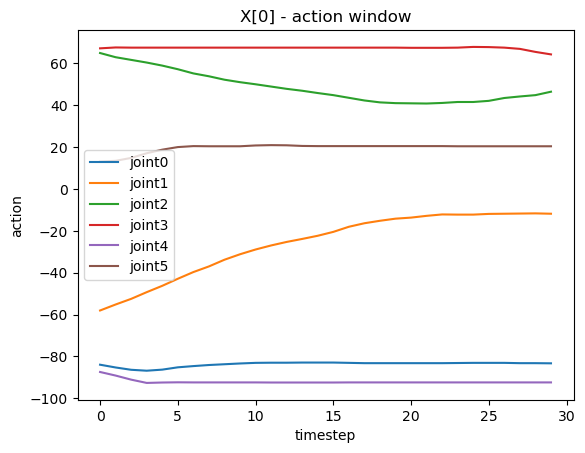

In [63]:
def plot_trajectory(traj, title="trajectory"):
    # traj: (T, 6)
    T = traj.shape[0]
    t = range(T)
    plt.figure()
    for j in range(traj.shape[1]):
        plt.plot(t, traj[:, j].numpy(), label=f"joint{j}")
    plt.title(title)
    plt.xlabel("timestep")
    plt.ylabel("action")
    plt.legend()
    plt.show()

traj = torch.cat((context,X.unsqueeze(1)), dim = 1)
plot_trajectory(traj[1].cpu(), "X[0] - action window")

In [65]:
def fit_action_normalizer(episodes, eps=1e-6):
    # episodes: list of (T, A)
    # think [(T1, A), (T2, A), ...]
    A_dim = episodes[0].shape[1]
    total = torch.zeros(A_dim) # dim 6
    total2 = torch.zeros(A_dim) # dim 6
    count = 0

    # so it seems ive set myself up to compute mean and std per action dimension

    for ep in episodes:
        ep = ep.float()
        total += ep.sum(dim=0) # sum over time, get (A,)
        total2 += (ep * ep).sum(dim=0) # sum over time, get (A,)
        count += ep.shape[0] # total number of timesteps

    mean = total / count
    var = total2 / count - mean * mean #using second momemt trick to calculate variance
    std = torch.sqrt(torch.clamp(var, min=eps))
    return mean, std

def normalize_episodes(episodes, mean, std):
    return [(ep.float() - mean) / std for ep in episodes]

def denormalize_actions(x, mean, std):
    return x * std + mean

### Time Embedding

In [66]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: (B,) float in [0,1] or (B,) int steps cast to float
        returns: (B, dim)
        """
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, device=t.device).float() / (half - 1)
        )
        # (B, half)
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb

class TimeMLP(nn.Module):
    def __init__(self, time_dim: int, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(time_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim),
        )

    def forward(self, t_emb: torch.Tensor) -> torch.Tensor:
        return self.net(t_emb)


In [67]:
class AdaRMSNorm(nn.Module):
    def __init__(self, dim: int, cond_dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        self.to_scale = nn.Sequential(
            nn.SiLU(),
            nn.Linear(cond_dim, dim, bias=True),
        )

    def forward(self, x: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        cond: (B, cond_dim)
        """
        rms = x.pow(2).mean(dim=-1, keepdim=True).add(self.eps).sqrt()
        x_norm = x / rms
        scale = self.to_scale(cond).unsqueeze(1)  # (B, 1, D)
        return x_norm * (self.weight + scale)


### Model

In [68]:
class AttentionHead(nn.Module):
    """ Single Attention Head: for Self-Attention or Cross-Attention
    Args:
        head_dim: dimension of each attention head
        embed_dim: input embedding dimension
        dropout: dropout rate
        causal: whether to apply causal masking
        max_len: maximum sequence (context) length (required if causal is True) 
      
    Returns:
        out: output tensor after attention (B, Tq, head_dim)
    
     """
    def __init__(self, head_dim, embed_dim, dropout=0.0, causal=False, max_len=None):
        super().__init__()
        self.key = nn.Linear(embed_dim, head_dim, bias=False)
        self.query = nn.Linear(embed_dim, head_dim, bias=False)
        self.value = nn.Linear(embed_dim, head_dim, bias=False)
        self.atten_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)

        self.causal = causal
        if causal:
            assert max_len is not None, "max_len required for causal mask"
            mask = torch.tril(torch.ones(max_len, max_len)).view(1, max_len, max_len)
            self.register_buffer("mask", mask)

    def forward(self, x_q, x_kv=None):
        # x_q: (B, Tq, E), x_kv: (B, Tk, E)
        if x_kv is None:
            x_kv = x_q

        B, Tq, _ = x_q.shape
        Tk = x_kv.shape[1]

        q = self.query(x_q)
        k = self.key(x_kv)
        v = self.value(x_kv)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

        if self.causal:
            att = att.masked_fill(self.mask[:, :Tq, :Tk] == 0, float("-inf"))

        att = F.softmax(att, dim=-1)
        att = self.atten_drop(att)

        out = att @ v
        out = self.resid_drop(out)
        return out


In [69]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, head_dim, dropout=0.0, causal=False, max_len=None):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(head_dim, embed_dim, dropout, causal, max_len) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_dim, embed_dim, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, x_kv=None):
        multi_head_out = [h(x, x_kv) for h in self.heads]  # list of (B, T, head_size)
        multi_head_concat = torch.cat(multi_head_out, dim=-1) # (B, T, num_heads * head_size)
        out = self.drop(self.proj(multi_head_concat))  # (B, T, embed_dim)
        
        return out

In [70]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, expansion=4, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, expansion*embed_dim),
            nn.GELU(),
            nn.Linear(expansion*embed_dim, embed_dim),
            nn.Dropout(dropout),
        )
    def forward(self, x): return self.net(x)


# Transformer Block with Self-Attention, Cross-Attention, and Feed-Forward Network
class Block(nn.Module):
    def __init__(self, embed_dim, n_head, t_cond, mlp_expansion=4, dropout=0.0):
        super().__init__()
        assert embed_dim % n_head == 0
        head_size = embed_dim // n_head

        self.ada_norm1 = AdaRMSNorm(embed_dim, t_cond)
        self.ada_norm2 = AdaRMSNorm(embed_dim, t_cond)
        self.ada_norm3 = AdaRMSNorm(embed_dim, t_cond)
        self.rms_norm = nn.RMSNorm(embed_dim)

        self.self_attn = MultiHeadAttention(n_head, embed_dim, head_size, dropout)
        self.cross_attn = MultiHeadAttention(n_head, embed_dim, head_size, dropout)
        self.mlp = FeedForward(embed_dim, expansion=mlp_expansion, dropout=dropout)

    def forward(self, t_cond, x, x_kv=None):
      
        x = x + self.self_attn(self.ada_norm1(x, t_cond))
        x = x + self.cross_attn(self.ada_norm2(x, t_cond), self.rms_norm(x_kv))
        x = x + self.mlp(self.ada_norm3(x, t_cond))
        return x

In [71]:
def init_weights(module: nn.Module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

    if module.__class__.__name__ in ["RMSNorm", "AdaRMSNorm"]:
        if hasattr(module, "weight"):
            nn.init.ones_(module.weight)

    if module.__class__.__name__ == "AdaRMSNorm":
        last = module.to_scale[-1]
        if isinstance(last, nn.Linear):
            nn.init.zeros_(last.weight)
            nn.init.zeros_(last.bias)

    # only for TimeMLP
    if isinstance(module, TimeMLP):
        last = module.net[-1]
        if isinstance(last, nn.Linear):
            nn.init.zeros_(last.weight)
            nn.init.zeros_(last.bias)



In [72]:
class MotorGPT(nn.Module):
    def __init__(self, embed_dim=128, time_dim=64, n_layer=4, n_head=4, dropout=0.0, traj_size=30):
        super().__init__()

        self.action_in = nn.Linear(6, embed_dim)
        self.action_out = nn.Linear(embed_dim, 6)

        self.context_pos_emb = nn.Embedding(traj_size -1, embed_dim)
        self.time_embed = SinusoidalTimeEmbedding(time_dim)
        self.time_mlp = TimeMLP(time_dim, embed_dim)

        self.blocks = nn.ModuleList([
            Block(embed_dim, n_head, embed_dim, dropout=dropout)
            for _ in range(n_layer)
        ])

        self.norm = nn.RMSNorm(embed_dim)

        self.apply(init_weights)

    def forward(self, a_noisy: torch.Tensor, t: torch.Tensor, past_actions: torch.Tensor) -> torch.Tensor:
        """
        a_noisy: (B, 6)          # single noisy action OR (B,K,6) later
        t: (B,)                  # flow time
        past_actions: (B, T, 6)  # context
        """
        t_cond = self.time_mlp(self.time_embed(t))

        x = self.action_in(a_noisy).unsqueeze(1)

        B, T, _ = past_actions.shape
        pos = self.context_pos_emb(torch.arange(T, device=past_actions.device)).unsqueeze(0)
        context = self.action_in(past_actions) + pos

        for blk in self.blocks:
            x = blk(t_cond, x, context)

        x = self.norm(x)
        x = self.action_out(x)

        out = x.squeeze(1)

        return out



### Training and Inference

In [73]:
class RectifiedFlowScheduler:
    def __init__(self, eps: float = 1e-5):
        self.eps = eps

    # sample time for the batch
    # t: (B,)
    def sample_t(self, batch_size:int, device):
        # avoiding exactly 0 or 1
        t = torch.rand(batch_size, device=device) * (1 - 2*self.eps) + self.eps
        return t
    
    #sample noise for the batch
    # noise: (B, 6)
    def sample_noise(self, shape, device):
        noise = torch.randn(shape, device=device)
        return noise
    
    # target vector field
    # xt: (B, 6)
    def bridge(self, x0, noise, t):
        # x0, z: (B, 6) or (B, K, 6) later
        # t: (B,) 
        while t.dim() < x0.dim():
            t = t.unsqueeze(1)
        xt = (1-t) * x0 +t * noise
        return xt
    
    def target_velocity(self, x0, noise):
        return noise - x0
    


In [74]:
def train_step(model, scheduler, batch, optimizer):
    x0, past_actions = batch  # x0 is next action
    B = x0.shape[0]
    device = x0.device

    t = scheduler.sample_t(B, device=device)           # (B,)
    z = scheduler.sample_noise(x0.shape, device=device) # (B,6)
    xt = scheduler.bridge(x0, z, t)                    # (B,6)
    v_target = scheduler.target_velocity(x0, z)        # (B,6)

    v_pred = model(a_noisy=xt, t=t, past_actions=past_actions)  # (B,6)

    loss = torch.mean((v_pred - v_target) ** 2)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # optional but helpful
    optimizer.step()

    return loss.item()


In [75]:
@torch.no_grad()
def sample_action(model, past_actions, n_steps=10):
    # past_actions: (B,T,6) normalized
    B = past_actions.shape[0]
    device = past_actions.device

    x = torch.randn(B, 6, device=device)  # start at noise (t=1)

    # time grid from 1 -> 0
    ts = torch.linspace(1.0, 0.0, n_steps, device=device)

    for i in range(n_steps - 1):
        t = ts[i].repeat(B)               # (B,)
        dt = ts[i+1] - ts[i]              # negative
        v = model(a_noisy=x, t=t, past_actions=past_actions)  # (B,6)
        x = x + dt * v                    # Euler step

    return x  # normalized action prediction (B,6)


In [76]:
# --- smoke test ---
torch.manual_seed(0)

# normalize
mean, std = fit_action_normalizer(train_eps)
train_eps_norm = normalize_episodes(train_eps, mean, std)

# batch
window_lens = prep_episode_metadata(train_eps_norm, trajectory_len=TRAJ_SIZE)
x0, ctx = get_batch_train(train_eps_norm, window_lens, trajectory_len=TRAJ_SIZE, batch_size=8, device=device)

# model + scheduler
model = MotorGPT(embed_dim=128, time_dim=64, n_layer=2, n_head=4, dropout=0.0, traj_size=TRAJ_SIZE).to(device)
scheduler = RectifiedFlowScheduler()
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

# forward + train step
loss = train_step(model, scheduler, (x0, ctx), opt)
print("smoke loss:", loss)
assert torch.isfinite(torch.tensor(loss)), "loss is not finite"


smoke loss: 2.5381860733032227
